# Homework 2

### Question 1

Prove or disprove:  ELU differentiable at 0.

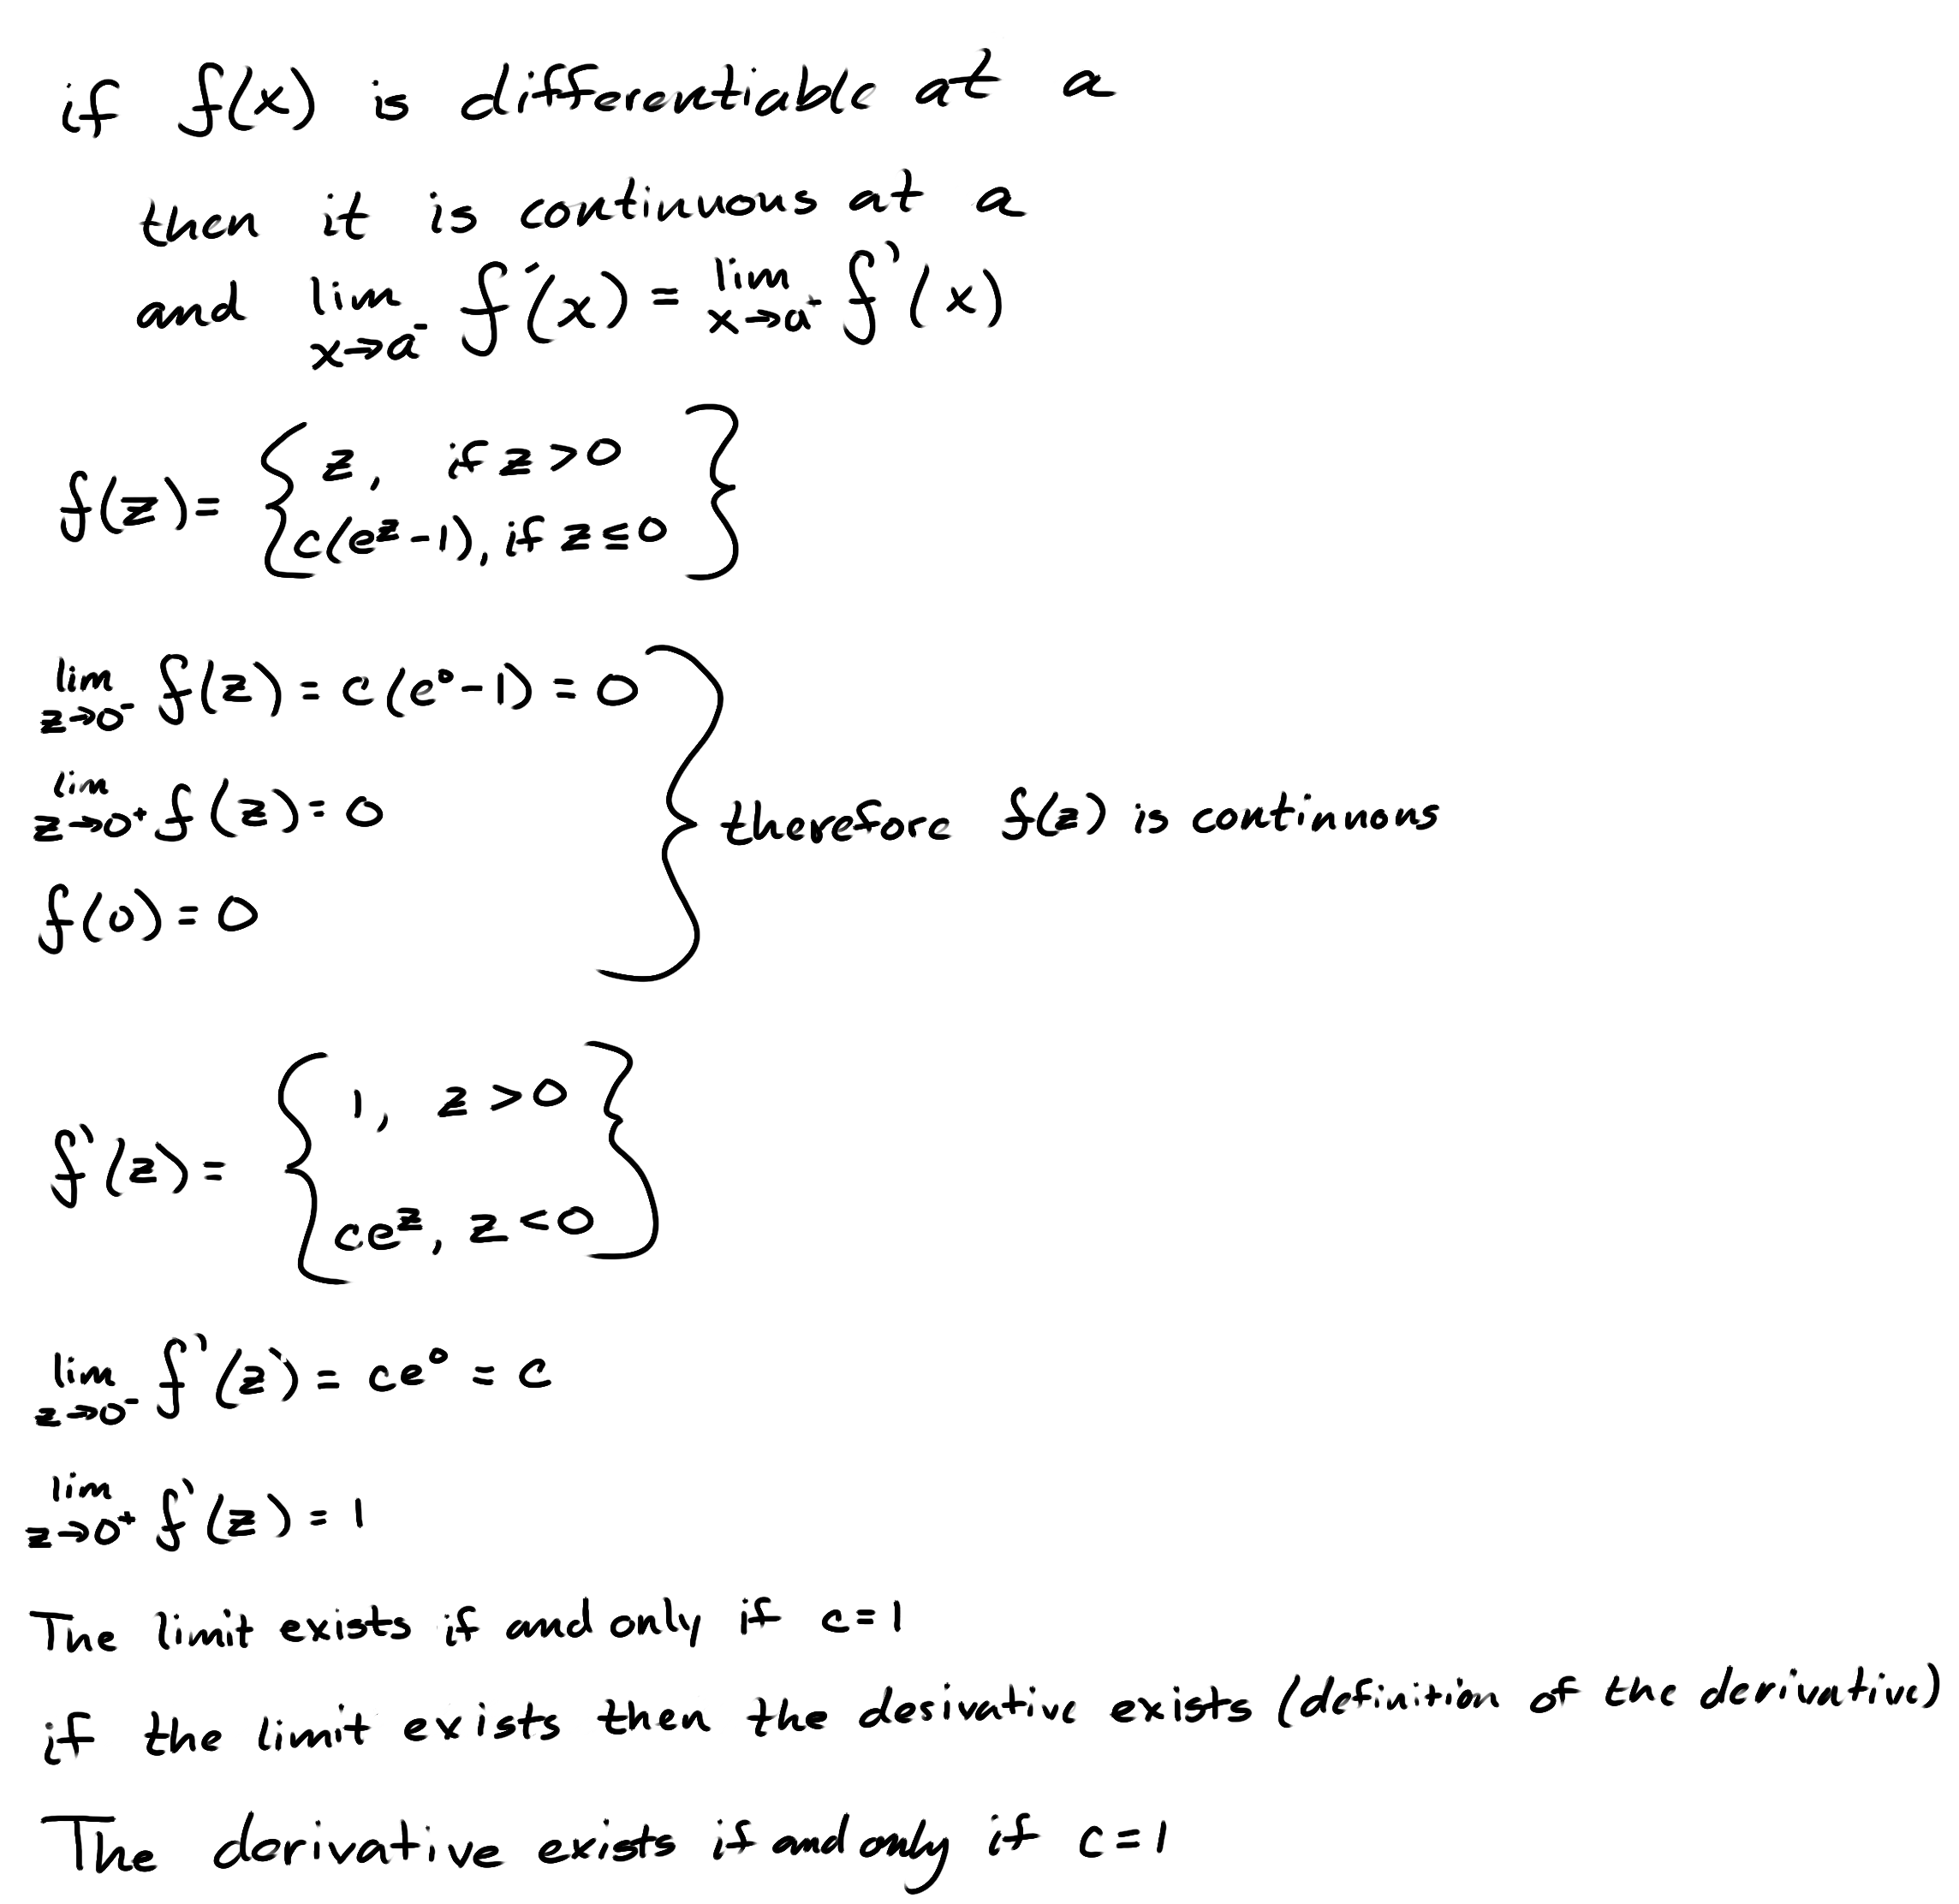

Draw the computational graph for f(w<sub>0</sub>+w<sub>1</sub>a<sub>1</sub>+w<sub>2</sub>a<sub>2</sub>).

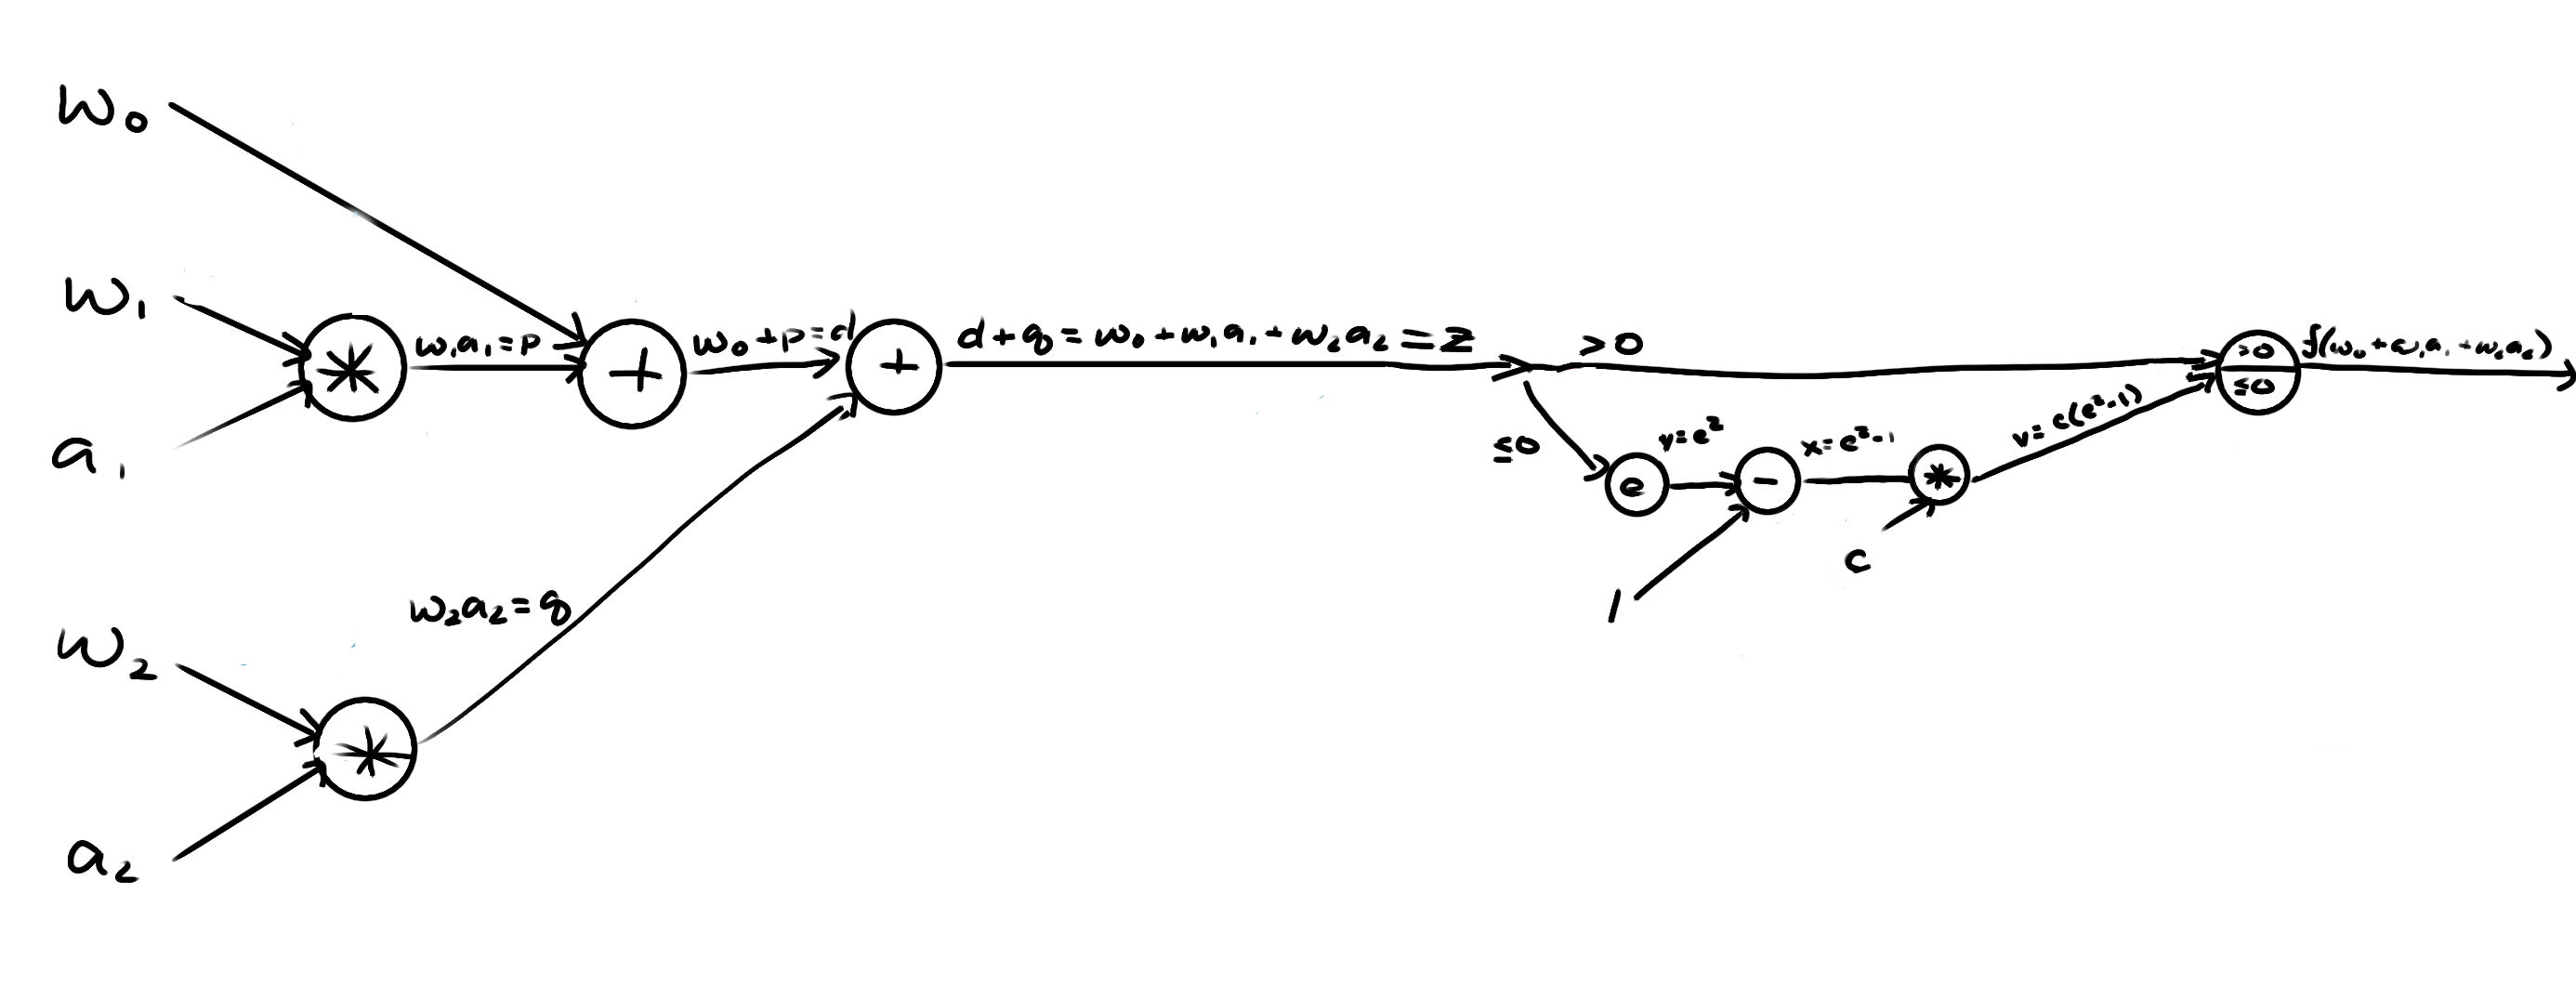

Compute the gradient when w<sub>0</sub> = 3, w<sub>1</sub> = -1, a<sub>1</sub> = 1, w<sub>2</sub> = 1, a<sub>2</sub>=-2 using backpropagation on your computational graph.

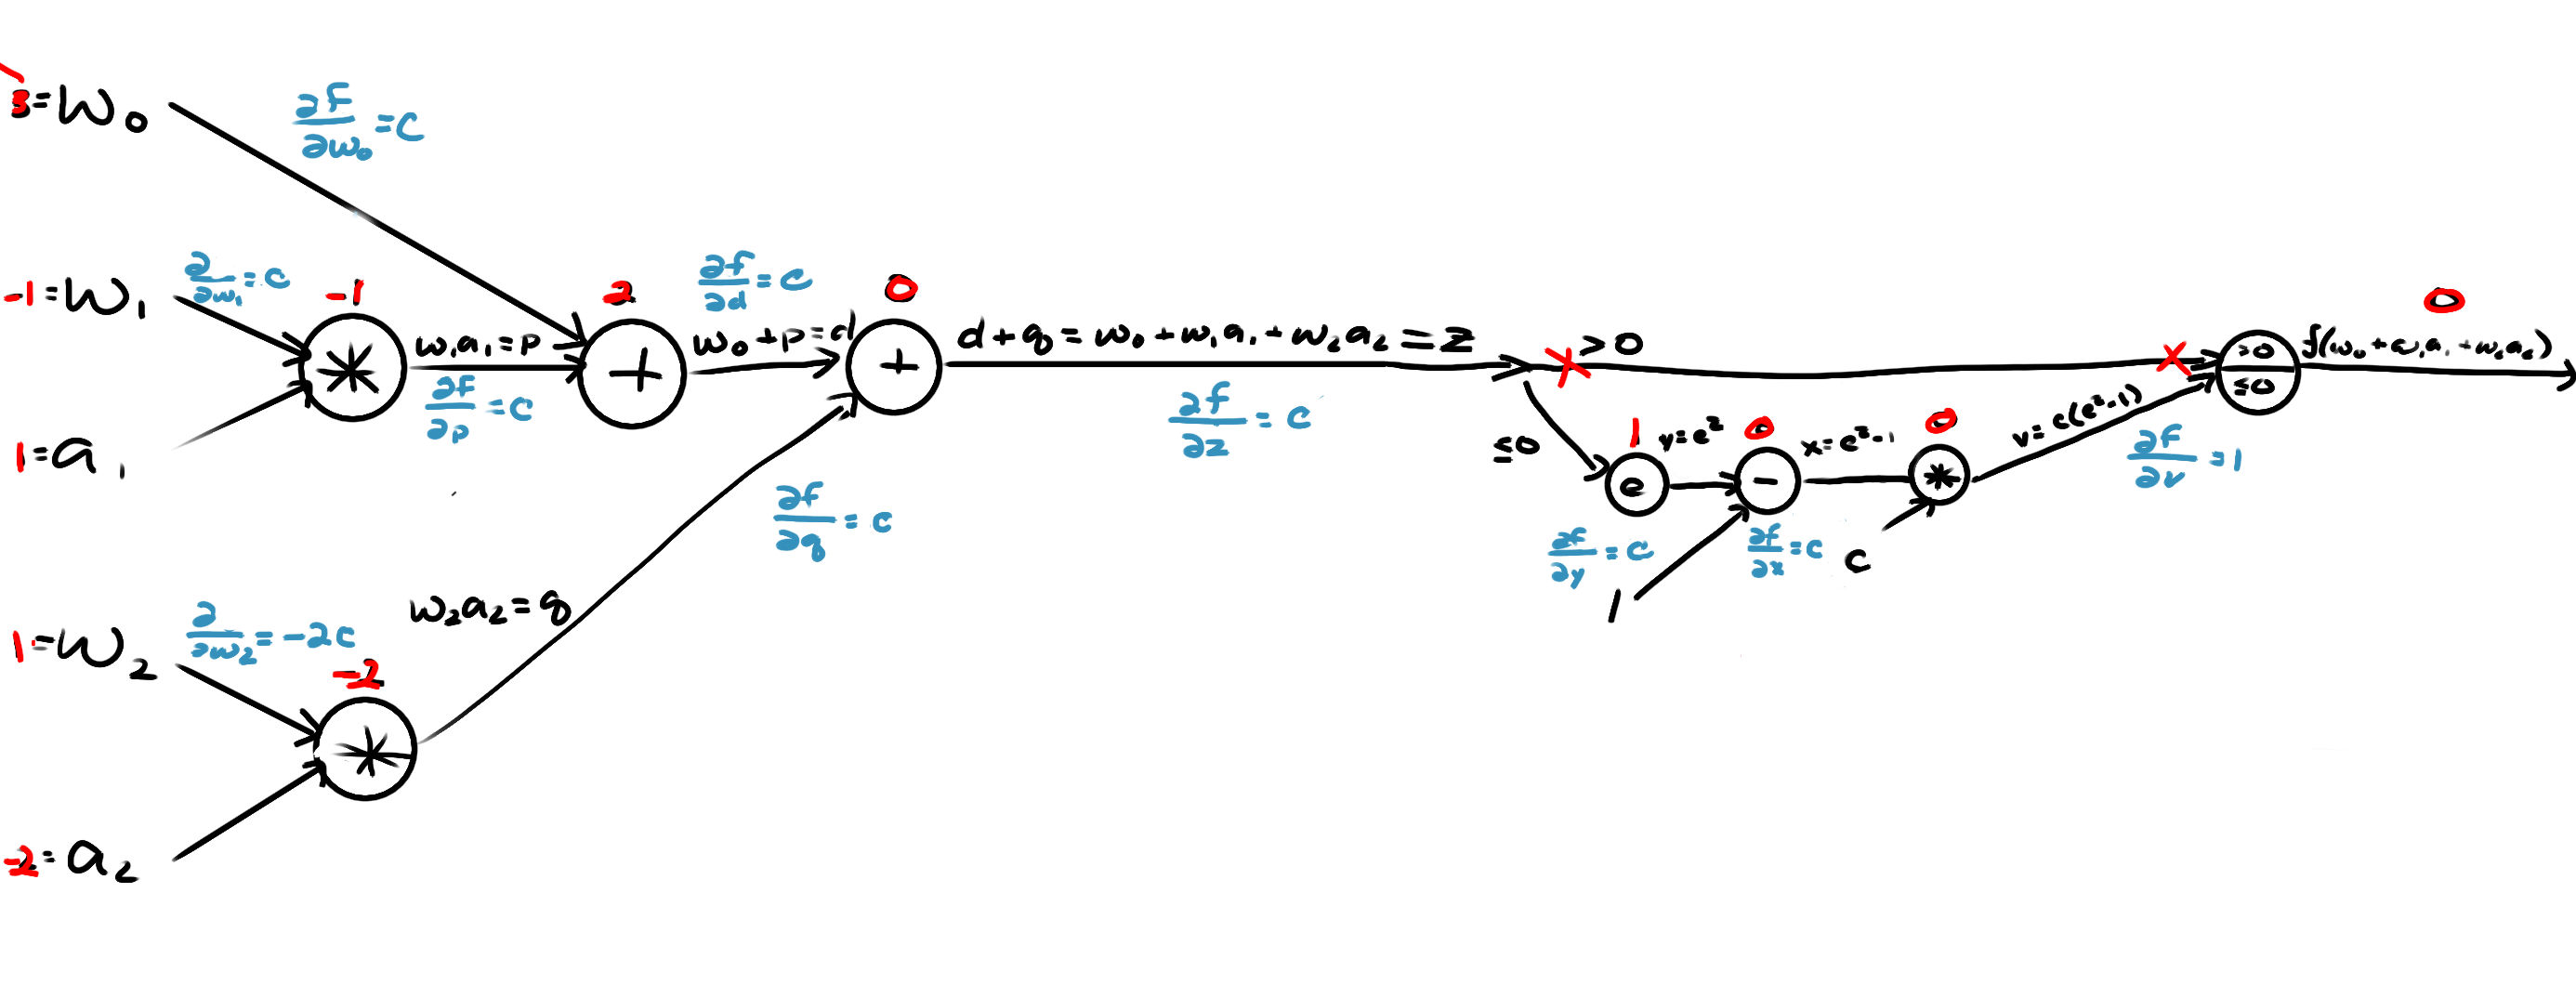

blue = derivative | red = feed-forward

### Question 2

Add rectified linear unit (ReLU) and ELU to the GitHub implementation of the feedforward neural network.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
import warnings

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

2021-10-02 16:54:31.586708: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-02 16:54:31.586728: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# This class is for a fully-connected feedforward neural network using stochastic gradient descent
#
# Inputs:
#
#   layers - a list of numbers of neurons in each layer
#
#   alpha - learning rate
#
#   lambda1 - L1 penalty coefficient
#
#   lambda2 - L2 penalty coefficient
#
#   batchSize - size of mini-batches for SGD
#
#   loss - string to choose which loss function to use:
#     'sum-of-squares'
#     'cross-entropy'

class FeedforwardNeuralNetwork:
    
    def __init__(self, layers, alpha = 0.1, lambda1 = 0, lambda2 = 0, batchSize = 32, loss = 'sum-of-squares', activation = 'sigmoid', d_activation = None, softmax = False):
        # list of weight matrices between layers
        self.W = []
        
        # network architecture will be a vector of numbers of nodes for each layer
        self.layers = layers
        
        # learning rate
        self.alpha = alpha
        
        # L1 penalty coefficient
        self.lambda1 = lambda1
        
        # L2 penalty coefficient
        self.lambda2 = lambda2
        
        # batch size
        self.batchSize = batchSize
        
        # loss function
        self.loss = loss
        
        self.softmax = softmax
        
        # activation function
        if activation == 'sigmoid':
            self.activation = self.sigmoid
            self.activationDerivative = self.sigmoidDerivative
        elif activation == 'relu':
            self.activation = self.relu
            self.activationDerivative = self.reluDerivative
        elif activation == 'elu':
            self.activation = self.elu
            self.activationDerivative = self.eluDerivative
        else:
            self.activation = activation
            self.activationDerivative = d_activation
        
        
        # initialize the weights (randomly) -- this is our initial guess for gradient descent
        
        # initialize the weights between layers (up to the next-to-last one) as normal random variables
        for i in np.arange(0, len(layers) - 2):
            self.W.append(np.random.randn(layers[i] + 1, layers[i + 1] + 1)/10000.0)
            
        # initialize weights between the last two layers (we don't want bias for the last one)
        self.W.append(np.random.randn(layers[-2] + 1, layers[-1])/10000.0)
        
    # define the activation function
    def sigmoid(self, x):
        return 1.0 / (1 + np.exp(-x))
    
    # define the activation derivative (where y is the OUTPUT of the activation function)
    def sigmoidDerivative(self, y):
        return y * (1 - y)
    
    def relu(self, x):
        return np.maximum(0, x)
    
    def reluDerivative(self, y):
        # 1 if y > 0 else 0
        return np.sign(y)
    
    def elu(self, x):
        return np.where(x > 0, x, np.exp(x) - 1)
    
    def eluDerivative(self, y):
        # e^x = dy/dx = y + 1 : x < 0
        return np.where(y > 0, 1, y + 1)
    
    def getNextBatch(self, X, y, batchSize):
        for i in np.arange(0, X.shape[0], batchSize):
            yield (X[i:i + batchSize], y[i:i + batchSize])
    
    # fit the model
    def fit(self, X, y, testX, testY, epochs = 10000, update = 1000, printPerformance = False, metricTransform = lambda y: y):
        # add a column of ones to the end of X
        X, y, testX, testY = X.copy(), y.copy(), testX.copy(), testY.copy()
        
        X = np.hstack((X, np.ones([X.shape[0],1])))
        losses = []
        trainAccuracies = []
        testAccuracies = []
        trainY = metricTransform(y)
        testY = metricTransform(testY)
        
        numberOfExamples = X.shape[0]

        for epoch in np.arange(0,epochs):
            
            # randomize the examples
            p = np.arange(0,X.shape[0])
            np.random.shuffle(p)
            X = X[p]
            y = y[p]

            # feed forward, backprop, and weight update
            for (x, target) in self.getNextBatch(X, y, self.batchSize):
                # make a list of output activations from the first layer
                # (just the original x values)
                A = [np.atleast_2d(x)]
                
                # feed forward
                for layer in np.arange(0, len(self.W)):
                    
                    # feed through one layer and apply activation function
                    net = A[layer].dot(self.W[layer])
                    
                    out = self.activation(net)
                    
                    # add our network output to the list of activations
                    A.append(out)
                    
                
                if self.softmax:
                    A[-1] = np.exp(A[-1])
                    magn = np.sum(A[-1], axis=1)[:, None]
                    A[-1] /= magn
                    self.loss = 'cross-entropy'
                    
                    
                # backpropagation (coming soon!)
                error = A[-1] - target
                    
                
                if self.loss == 'sum-of-squares':
                    D = [2 * error * self.activationDerivative(A[-1])]
                if self.loss == 'cross-entropy':
                    D = [error]
                
                # loop backwards over the layers to build up deltas
                for layer in np.arange(len(A) - 2, 0, -1):
                    delta = D[-1].dot(self.W[layer].T)
                    delta = delta * self.activationDerivative(A[layer])
                    D.append(delta)
                    
                # reverse the deltas since we looped in reverse
                D = D[::-1]
                
                # weight update
                for layer in np.arange(0, len(self.W)):
                    self.W[layer] -= self.alpha * (A[layer].T.dot(D[layer])
                                                   + 2 * (self.lambda2 / numberOfExamples) * self.W[layer]
                                                   + (self.lambda1 / numberOfExamples) * np.sign(self.W[layer]) * self.W[layer])

            # print the loss (or maybe more) each 'update' number of epochs
            if (epoch + 1) % update == 0:
                
                # compute the loss
                loss = self.computeLoss(X,y)

                # if we choose, compute the accuracy (this makes it run slower)
                if printPerformance:
                    predictedY = self.predict(testX)
                    predictedY = metricTransform(predictedY)
                    testAccuracy = accuracy_score(testY, predictedY)           

                    predictedY = self.predict(trainX)
                    predictedY = metricTransform(predictedY)
                    trainAccuracy = accuracy_score(trainY, predictedY)

                    testAccuracies.append(testAccuracy)
                    trainAccuracies.append(trainAccuracy)
                    losses.append(loss)
                    
                    # print('Epoch =', epoch + 1, '\tloss =', loss)
                    
                # otherwise, simply print the training loss
                else:
                    losses.append(loss)
                    print('Epoch =', epoch + 1, '\tloss =', loss)

        # if we chose to print the performance, plot loss, training accuracy, and test accuracy for each epoch
        if printPerformance:
            fig, ax1 = plt.subplots()

            # plot the losses
            p1 = ax1.plot(np.arange(0, epochs, update), losses, label = 'Loss')
            ax1.set_xlabel('Training Epoch')
            ax1.set_ylabel('Loss')

            # make another y axis using the same x axis
            ax2 = ax1.twinx()
            ax2.set_ylim([0.5, 1])
            
            # plot the accuracy
            p2 = ax2.plot(np.arange(0, epochs, update), trainAccuracies, label = 'Accuracy (train)', color = 'tab:orange')
            p3 = ax2.plot(np.arange(0, epochs, update), testAccuracies, label = 'Accuracy (test)', color = 'tab:green')
            ax2.set_ylabel('Accuracy')

            # add a legend
            ps = p1 + p2 + p3
            labs = [p.get_label() for p in ps]
            ax1.legend(ps, labs, loc=0)
            
    # feed data into the network and compute the outputs
    def predict(self, X, addOnes = True):
        
        # initialize data, be sure it's the right dimension
        p = np.atleast_2d(X)
        
        # add a column of 1s for bias
        if addOnes:
            p = np.hstack((p, np.ones([X.shape[0],1])))
        
        # feed forward!
        for layer in np.arange(0, len(self.W)):
            p = self.activation(np.dot(p, self.W[layer]))
        

        if self.softmax:
            p = np.exp(p)
            magn = np.sum(p, axis=1)[:, None]
            p /= magn
            
        # return the predictions
        return p
    
    # compute the loss function
    def computeLoss(self, X, y):
        
        # initialize data to the right dimension
        y = np.atleast_2d(y)
        
        # feed the datapoints through the network to get predicted outputs
        predictions = self.predict(X, addOnes = False)
        
        # if the loss function is sum of squares, compute it
        if self.loss == 'sum-of-squares':
            loss = np.sum((predictions - y)**2) / 2.0
            
        # if the loss function is cross-entropy, compute it
        if self.loss == 'cross-entropy':
            loss = np.sum(np.nan_to_num(-y*np.log(predictions)-(1-y)*np.log(1-predictions)))
        
        # add L1 and L2 penalty
        L1penalty = 0
        L2penalty = 0
        
        # add up L1 and L2 penalties from each layer
        for layer in np.arange(0,len(self.W)):
            L1penalty += np.sum(np.abs(self.W[layer]))
            L2penalty += np.sum(self.W[layer] ** 2)
        
        # L1 and L2 penalties to the loss
        loss += (self.lambda1 / X.shape[0]) * L1penalty
        loss += (self.lambda2 / X.shape[0]) * L2penalty
        
        return loss
    
    print("Successfully created feedforward neural network class.")

Successfully created feedforward neural network class.


In [3]:
# A small test of standard regression

trainX = np.random.rand(10000,2)
trainY = (np.array([2 ,1]) * trainX).sum(axis=1)[:, None]

testX = np.random.rand(10000,2)
testY = (np.array([2 ,1]) * testX).sum(axis=1)[:, None]

print('TrainX :\n', trainX[:5])
print('TrainY :\n', trainY[:5])


print("Fit the model to the training data")
model = FeedforwardNeuralNetwork([2, 4, 1], 0.01, 0.0, 0.0, 32, 'sum-of-squares', 'relu')
model.fit(trainX, trainY, testX, testY, 10, 1, printPerformance=False)

print("Avg Distance From Correct")
predictedY = model.predict(testX)
print(np.mean(np.abs(testY - predictedY)))

print(np.hstack([testY[:5], predictedY[:5]]))

TrainX :
 [[0.31608296 0.82696223]
 [0.61699915 0.31653827]
 [0.33824155 0.45590884]
 [0.23212697 0.42788108]
 [0.56241634 0.77975868]]
TrainY :
 [[1.45912814]
 [1.55053657]
 [1.13239194]
 [0.89213502]
 [1.90459137]]
Fit the model to the training data
Epoch = 1 	loss = 102.48224464005405
Epoch = 2 	loss = 1316.6818403681991
Epoch = 3 	loss = 542.1043423084847
Epoch = 4 	loss = 1127.5062012559374
Epoch = 5 	loss = 18.78715518240001
Epoch = 6 	loss = 3.5533272000337393
Epoch = 7 	loss = 61.50141333735527
Epoch = 8 	loss = 6.992236127842954
Epoch = 9 	loss = 69.99786235370334
Epoch = 10 	loss = 266.1380465350568
Avg Distance From Correct
0.2172359406661907
[[1.56148018 1.31335458]
 [1.4020245  1.25281173]
 [2.08562611 1.86376829]
 [2.16465925 1.88987461]
 [2.22788538 1.89930487]]


### Question 3

Apply  your  implementation  to  classifying  the **MNIST** dataset  using  the  ELU  or  ReLU activation function.  Use at least 10,000 images in your training set.

### Question 4

**Tune  hyperparameters** to  improve  your  testing  accuracy  on  MNIST.  Based  on  initial results, choose at least two hyperparameters to tune and **explain the reasoning for your strategy**.  Run at least 10 experiments.

In [4]:
# supress log warnings
import warnings
warnings.filterwarnings('ignore')

# load the full MNIST dataset: both data and labels
print("Loading MNIST data")
((trainX, trainY), (testX, testY)) = mnist.load_data()
print("MNIST loaded.")

# scale the data to values in [0,1]
trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

# reshape the data

# Data for regression
trainX = trainX.reshape([60000, 28*28])[:60000]
trainY = to_categorical(trainY)[:60000]
# Data for final validation
valX = testX.reshape([10000, 28*28])[:5000]
valY = to_categorical(testY)[:5000]
# Data for hyperparameter tuning
testX = testX.reshape([10000, 28*28])[5000:]
testY = to_categorical(testY)[5000:]

print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

Loading MNIST data
MNIST loaded.
(60000, 784)
(60000, 10)
(5000, 784)
(5000, 10)


Fit the model to the training data
Test set accuracy
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       520
           1       0.99      0.97      0.98       564
           2       0.96      0.92      0.94       502
           3       0.98      0.94      0.96       510
           4       0.96      0.97      0.97       482
           5       0.93      0.96      0.95       436
           6       0.96      0.99      0.97       496
           7       0.96      0.98      0.97       516
           8       0.91      0.95      0.93       485
           9       0.98      0.96      0.97       489

    accuracy                           0.96      5000
   macro avg       0.96      0.96      0.96      5000
weighted avg       0.96      0.96      0.96      5000



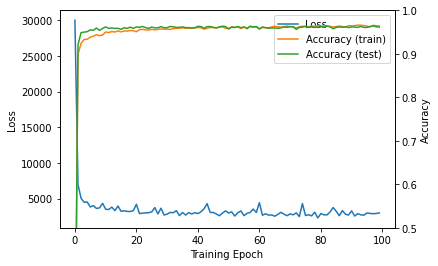

In [5]:
#1 First Run

print("Fit the model to the training data")

model = FeedforwardNeuralNetwork([784, 16, 16, 10],
                                 alpha = 0.01,
                                 lambda1 = 0.0,
                                 lambda2 = 0.0, 
                                 batchSize = 32, 
                                 loss = 'sum-of-squares',
                                 activation = 'elu'
                            )
model.fit(trainX, trainY, testX, testY, 100, 1, printPerformance=True, metricTransform = lambda y: y.argmax(axis=1))

print("Test set accuracy")
predictedY = model.predict(testX.copy())

predictedY = predictedY.argmax(axis=1)
_testY = testY.argmax(axis=1)
print(classification_report(_testY, predictedY))

# print('Test Confusion Matrix:')
# sn.heatmap(confusion_matrix(_testY, predictedY))

Fit the model to the training data
Test set accuracy
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       520
           1       0.99      0.99      0.99       564
           2       0.96      0.94      0.95       502
           3       0.96      0.92      0.94       510
           4       0.96      0.97      0.97       482
           5       0.96      0.93      0.94       436
           6       0.94      0.97      0.96       496
           7       0.98      0.98      0.98       516
           8       0.91      0.95      0.93       485
           9       0.97      0.94      0.96       489

    accuracy                           0.96      5000
   macro avg       0.96      0.96      0.96      5000
weighted avg       0.96      0.96      0.96      5000



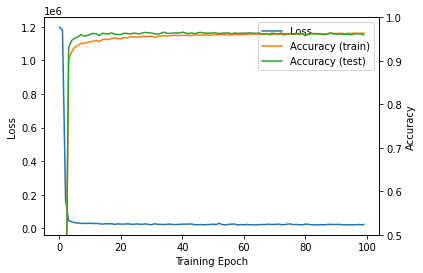

In [6]:
#2 Try cross-entropy loss

print("Fit the model to the training data")

model = FeedforwardNeuralNetwork([784, 16, 16, 10],
                                 alpha = 0.01,
                                 lambda1 = 0.0,
                                 lambda2 = 0.0, 
                                 batchSize = 32, 
                                 loss = 'cross-entropy',
                                 activation = 'elu'
                            )
model.fit(trainX, trainY, testX, testY, 100, 1, printPerformance=True, metricTransform = lambda y: y.argmax(axis=1))

print("Test set accuracy")
predictedY = model.predict(testX.copy())

predictedY = predictedY.argmax(axis=1)
_testY = testY.argmax(axis=1)
print(classification_report(_testY, predictedY))

# print('Test Confusion Matrix:')
# sn.heatmap(confusion_matrix(_testY, predictedY))

Fit the model to the training data
Test set accuracy
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       520
           1       0.99      0.98      0.99       564
           2       0.97      0.94      0.96       502
           3       0.95      0.92      0.93       510
           4       0.98      0.96      0.97       482
           5       0.94      0.93      0.94       436
           6       0.95      0.98      0.97       496
           7       0.98      0.98      0.98       516
           8       0.85      0.95      0.90       485
           9       0.97      0.95      0.96       489

    accuracy                           0.96      5000
   macro avg       0.96      0.96      0.96      5000
weighted avg       0.96      0.96      0.96      5000



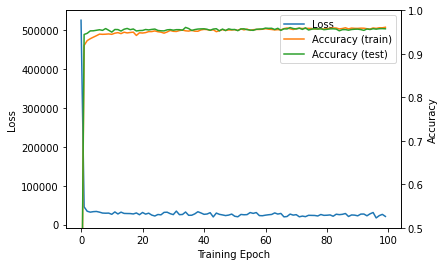

In [7]:
#3 Less varience in accuracy by class
# Not reaching high accuracy on even on training set: Local minima? Increase learning rate

print("Fit the model to the training data")

model = FeedforwardNeuralNetwork([784, 16, 16, 10],
                                 alpha = 0.025,
                                 lambda1 = 0.0,
                                 lambda2 = 0.0, 
                                 batchSize = 32, 
                                 loss = 'cross-entropy',
                                 activation = 'elu'
                            )
model.fit(trainX, trainY, testX, testY, 100, 1, printPerformance=True, metricTransform = lambda y: y.argmax(axis=1))

print("Test set accuracy")
predictedY = model.predict(testX)

predictedY = predictedY.argmax(axis=1)
_testY = testY.argmax(axis=1)
print(classification_report(_testY, predictedY))

# print('Test Confusion Matrix:')
# sn.heatmap(confusion_matrix(_testY, predictedY))

Fit the model to the training data
Test set accuracy
              precision    recall  f1-score   support

           0     0.9923    0.9923    0.9923       520
           1     1.0000    0.9894    0.9947       564
           2     0.9840    0.9801    0.9820       502
           3     0.9821    0.9686    0.9753       510
           4     0.9894    0.9689    0.9790       482
           5     0.9640    0.9817    0.9727       436
           6     0.9800    0.9879    0.9839       496
           7     0.9714    0.9864    0.9788       516
           8     0.9671    0.9711    0.9691       485
           9     0.9715    0.9775    0.9745       489

    accuracy                         0.9806      5000
   macro avg     0.9802    0.9804    0.9803      5000
weighted avg     0.9807    0.9806    0.9806      5000



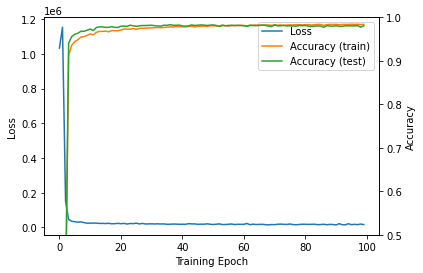

In [8]:
#4 Chaotic Convergence: revert learning rate
# Not reaching high accuracy on even on training set: underfitting? increase width


print("Fit the model to the training data")

model = FeedforwardNeuralNetwork([784, 32, 16, 10],
                                 alpha = 0.01,
                                 lambda1 = 0.0,
                                 lambda2 = 0.0, 
                                 batchSize = 32, 
                                 loss = 'cross-entropy',
                                 activation = 'elu'
                            )
model.fit(trainX, trainY, testX, testY, 100, 1, printPerformance=True, metricTransform = lambda y: y.argmax(axis=1))

print("Test set accuracy")
predictedY = model.predict(testX)

predictedY = predictedY.argmax(axis=1)
_testY = testY.argmax(axis=1)
print(classification_report(_testY, predictedY, digits=4))

# print('Test Confusion Matrix:')
# sn.heatmap(confusion_matrix(_testY, predictedY))

Fit the model to the training data
Test set accuracy
              precision    recall  f1-score   support

           0     0.9865    0.9865    0.9865       520
           1     0.9964    0.9876    0.9920       564
           2     0.9724    0.9821    0.9772       502
           3     0.9707    0.9745    0.9726       510
           4     0.9853    0.9710    0.9781       482
           5     0.9814    0.9656    0.9734       436
           6     0.9761    0.9899    0.9830       496
           7     0.9658    0.9845    0.9750       516
           8     0.9693    0.9753    0.9723       485
           9     0.9813    0.9652    0.9732       489

    accuracy                         0.9786      5000
   macro avg     0.9785    0.9782    0.9783      5000
weighted avg     0.9787    0.9786    0.9786      5000



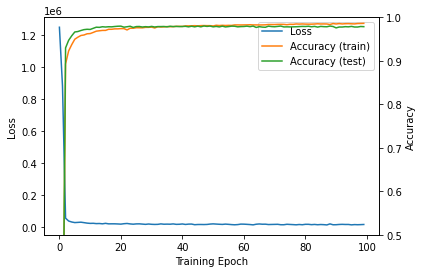

In [9]:
#5 Drastically improved accuracy
# Slightly Overfitted: increase regularization

print("Fit the model to the training data")

model = FeedforwardNeuralNetwork([784, 32, 16, 10],
                                 alpha = 0.01,
                                 lambda1 = 0.0,
                                 lambda2 = 1.0, 
                                 batchSize = 32, 
                                 loss = 'cross-entropy',
                                 activation = 'elu'
                            )
model.fit(trainX, trainY, testX, testY, 100, 1, printPerformance=True, metricTransform = lambda y: y.argmax(axis=1))

print("Test set accuracy")
predictedY = model.predict(testX)

predictedY = predictedY.argmax(axis=1)
_testY = testY.argmax(axis=1)
print(classification_report(_testY, predictedY, digits=4))

Test Confusion Matrix:


<AxesSubplot:>

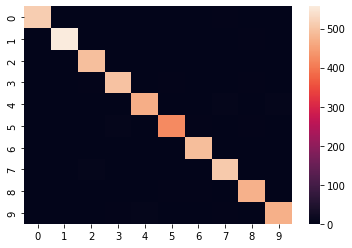

In [10]:
print('Test Confusion Matrix:')
sn.heatmap(confusion_matrix(_testY, predictedY))

Fit the model to the training data
Test set accuracy
              precision    recall  f1-score   support

           0     0.9865    0.9865    0.9865       520
           1     0.9911    0.9858    0.9884       564
           2     0.9758    0.9641    0.9699       502
           3     0.9537    0.9686    0.9611       510
           4     0.9936    0.9730    0.9832       482
           5     0.9678    0.9656    0.9667       436
           6     0.9647    0.9919    0.9781       496
           7     0.9826    0.9826    0.9826       516
           8     0.9415    0.9629    0.9521       485
           9     0.9811    0.9550    0.9679       489

    accuracy                         0.9740      5000
   macro avg     0.9738    0.9736    0.9737      5000
weighted avg     0.9742    0.9740    0.9740      5000



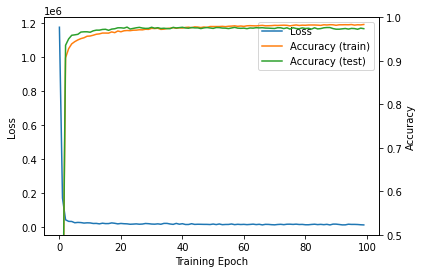

In [11]:
#6 Very high accuracy and high low cross-entropy
# Slight confusion between 2 and 7
# Virtually no overfitting
# Increase width slightly

print("Fit the model to the training data")

model = FeedforwardNeuralNetwork([784, 32, 24, 10],
                                 alpha = 0.01,
                                 lambda1 = 0.0,
                                 lambda2 = 1.0, 
                                 batchSize = 32, 
                                 loss = 'cross-entropy',
                                 activation = 'elu'
                            )
model.fit(trainX, trainY, testX, testY, 100, 1, printPerformance=True, metricTransform = lambda y: y.argmax(axis=1))

print("Test set accuracy")
predictedY = model.predict(testX)

predictedY = predictedY.argmax(axis=1)
_testY = testY.argmax(axis=1)
print(classification_report(_testY, predictedY, digits=4))

Fit the model to the training data
Test set accuracy
              precision    recall  f1-score   support

           0     0.9904    0.9923    0.9914       520
           1     0.9964    0.9929    0.9947       564
           2     0.9801    0.9821    0.9811       502
           3     0.9745    0.9745    0.9745       510
           4     0.9958    0.9772    0.9864       482
           5     0.9613    0.9679    0.9646       436
           6     0.9880    0.9940    0.9910       496
           7     0.9827    0.9903    0.9865       516
           8     0.9676    0.9856    0.9765       485
           9     0.9875    0.9673    0.9773       489

    accuracy                         0.9828      5000
   macro avg     0.9824    0.9824    0.9824      5000
weighted avg     0.9829    0.9828    0.9828      5000



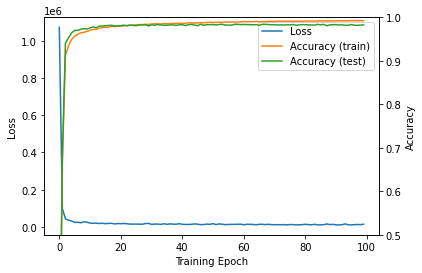

In [12]:
#7 Accuracy continues to increase with width increase width more

print("Fit the model to the training data")

model = FeedforwardNeuralNetwork([784, 48, 32, 10],
                                 alpha = 0.01,
                                 lambda1 = 0.0,
                                 lambda2 = 1.0, 
                                 batchSize = 32, 
                                 loss = 'cross-entropy',
                                 activation = 'elu'
                            )
model.fit(trainX, trainY, testX, testY, 100, 1, printPerformance=True, metricTransform = lambda y: y.argmax(axis=1))

print("Test set accuracy")
predictedY = model.predict(testX)

predictedY = predictedY.argmax(axis=1)
_testY = testY.argmax(axis=1)
print(classification_report(_testY, predictedY, digits=4))

Fit the model to the training data
Test set accuracy
              precision    recall  f1-score   support

           0     0.9885    0.9942    0.9914       520
           1     0.9911    0.9911    0.9911       564
           2     0.9782    0.9841    0.9811       502
           3     0.9785    0.9804    0.9794       510
           4     0.9916    0.9793    0.9854       482
           5     0.9860    0.9725    0.9792       436
           6     0.9900    0.9940    0.9920       496
           7     0.9922    0.9884    0.9903       516
           8     0.9737    0.9918    0.9826       485
           9     0.9835    0.9755    0.9795       489

    accuracy                         0.9854      5000
   macro avg     0.9853    0.9851    0.9852      5000
weighted avg     0.9854    0.9854    0.9854      5000



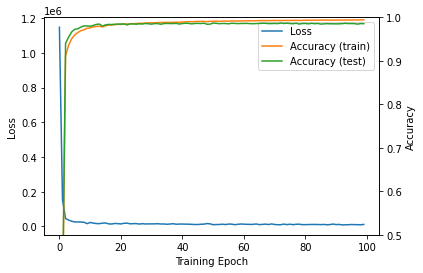

In [13]:
#8 Accuracy continues to increase with width increase width more

print("Fit the model to the training data")

model = FeedforwardNeuralNetwork([784, 64, 32, 10],
                                 alpha = 0.01,
                                 lambda1 = 0.0,
                                 lambda2 = 1.0, 
                                 batchSize = 32, 
                                 loss = 'cross-entropy',
                                 activation = 'elu'
                            )
model.fit(trainX, trainY, testX, testY, 100, 1, printPerformance=True, metricTransform = lambda y: y.argmax(axis=1))

print("Test set accuracy")
predictedY = model.predict(testX)

predictedY = predictedY.argmax(axis=1)
_testY = testY.argmax(axis=1)
print(classification_report(_testY, predictedY, digits=4))

Fit the model to the training data
Test set accuracy
              precision    recall  f1-score   support

           0     0.9885    0.9885    0.9885       520
           1     0.9982    0.9894    0.9938       564
           2     0.9762    0.9821    0.9791       502
           3     0.9746    0.9765    0.9755       510
           4     0.9958    0.9876    0.9917       482
           5     0.9700    0.9656    0.9678       436
           6     0.9821    0.9940    0.9880       496
           7     0.9808    0.9903    0.9855       516
           8     0.9715    0.9835    0.9775       485
           9     0.9896    0.9693    0.9793       489

    accuracy                         0.9830      5000
   macro avg     0.9827    0.9827    0.9827      5000
weighted avg     0.9831    0.9830    0.9830      5000



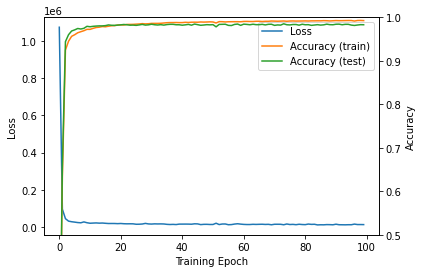

In [14]:
#9 Overfitting observed (flat line testing accuracy) | increase regularization

print("Fit the model to the training data")

model = FeedforwardNeuralNetwork([784, 48, 32, 10],
                                 alpha = 0.01,
                                 lambda1 = 0.0,
                                 lambda2 = 2.0, 
                                 batchSize = 32, 
                                 loss = 'cross-entropy',
                                 activation = 'elu'
                            )
model.fit(trainX, trainY, testX, testY, 100, 1, printPerformance=True, metricTransform = lambda y: y.argmax(axis=1))

print("Test set accuracy")
predictedY = model.predict(testX)

predictedY = predictedY.argmax(axis=1)
_testY = testY.argmax(axis=1)
print(classification_report(_testY, predictedY, digits=4))

Fit the model to the training data
Test set accuracy
              precision    recall  f1-score   support

           0     0.9904    0.9904    0.9904       520
           1     1.0000    0.9894    0.9947       564
           2     0.9841    0.9841    0.9841       502
           3     0.9598    0.9824    0.9709       510
           4     0.9958    0.9793    0.9874       482
           5     0.9905    0.9587    0.9744       436
           6     0.9725    0.9980    0.9851       496
           7     0.9769    0.9845    0.9807       516
           8     0.9715    0.9856    0.9785       485
           9     0.9854    0.9693    0.9773       489

    accuracy                         0.9826      5000
   macro avg     0.9827    0.9822    0.9823      5000
weighted avg     0.9828    0.9826    0.9826      5000



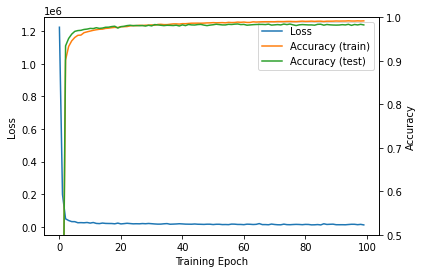

In [15]:
#10 Accuracy decreased but overfitting observed (flat line testing accuracy) | change type of regularization

print("Fit the model to the training data")

model = FeedforwardNeuralNetwork([784, 48, 32, 10],
                                 alpha = 0.01,
                                 lambda1 = 0.5,
                                 lambda2 = 1.0, 
                                 batchSize = 32, 
                                 loss = 'cross-entropy',
                                 activation = 'elu'
                            )
model.fit(trainX, trainY, testX, testY, 100, 1, printPerformance=True, metricTransform = lambda y: y.argmax(axis=1))

print("Test set accuracy")
predictedY = model.predict(testX)

predictedY = predictedY.argmax(axis=1)
_testY = testY.argmax(axis=1)
print(classification_report(_testY, predictedY, digits=4))

Fit the model to the training data
Test set accuracy
              precision    recall  f1-score   support

           0     0.9904    0.9885    0.9894       520
           1     0.9912    0.9947    0.9929       564
           2     0.9880    0.9880    0.9880       502
           3     0.9804    0.9804    0.9804       510
           4     0.9793    0.9834    0.9814       482
           5     0.9795    0.9839    0.9817       436
           6     0.9880    0.9919    0.9899       496
           7     0.9846    0.9884    0.9865       516
           8     0.9854    0.9773    0.9814       485
           9     0.9793    0.9693    0.9743       489

    accuracy                         0.9848      5000
   macro avg     0.9846    0.9846    0.9846      5000
weighted avg     0.9848    0.9848    0.9848      5000



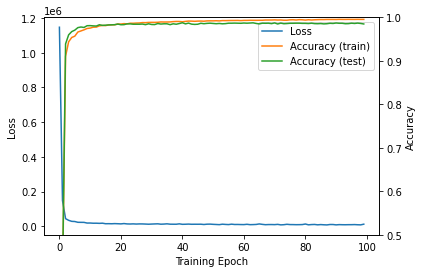

In [16]:
#11 Accuracy futher decreased | revert weight decay, attempt to reduce batch size

print("Fit the model to the training data")

model = FeedforwardNeuralNetwork([784, 64, 32, 10],
                                 alpha = 0.01,
                                 lambda1 = 0.0,
                                 lambda2 = 1.0, 
                                 batchSize = 16, 
                                 loss = 'cross-entropy',
                                 activation = 'elu'
                            )
model.fit(trainX, trainY, testX, testY, 100, 1, printPerformance=True, metricTransform = lambda y: y.argmax(axis=1))

print("Test set accuracy")
predictedY = model.predict(testX)

predictedY = predictedY.argmax(axis=1)
_testY = testY.argmax(axis=1)
print(classification_report(_testY, predictedY, digits=4))

Fit the model to the training data
Validation set accuracy
              precision    recall  f1-score   support

           0     0.9700    0.9826    0.9762       460
           1     0.9792    0.9895    0.9843       571
           2     0.9576    0.9811    0.9692       530
           3     0.9525    0.9620    0.9572       500
           4     0.9674    0.9500    0.9586       500
           5     0.9778    0.9671    0.9724       456
           6     0.9845    0.9654    0.9749       462
           7     0.9784    0.9727    0.9755       512
           8     0.9731    0.9611    0.9671       489
           9     0.9521    0.9558    0.9539       520

    accuracy                         0.9690      5000
   macro avg     0.9693    0.9687    0.9689      5000
weighted avg     0.9691    0.9690    0.9690      5000



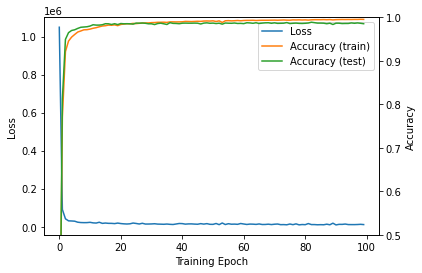

In [18]:
# Perform final analysis

print("Fit the model to the training data")

model = FeedforwardNeuralNetwork([784, 64, 32, 10],
                                 alpha = 0.01,
                                 lambda1 = 0.0,
                                 lambda2 = 1.0, 
                                 batchSize = 32, 
                                 loss = 'cross-entropy',
                                 activation = 'elu'
                            )
model.fit(trainX, trainY, testX, testY, 100, 1, printPerformance=True, metricTransform = lambda y: y.argmax(axis=1))

print("Validation set accuracy")
predictedY = model.predict(valX)

predictedY = predictedY.argmax(axis=1)
_valY = valY.argmax(axis=1)
print(classification_report(_valY, predictedY, digits=4))

Test Confusion Matrix:


<AxesSubplot:>

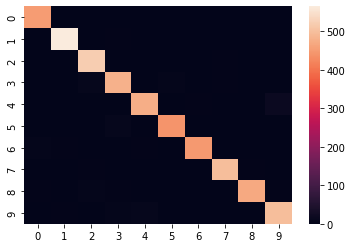

In [20]:
print('Test Confusion Matrix:')
sn.heatmap(confusion_matrix(_valY, predictedY))